In [1]:
import time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# Load dataset
x, Y = datasets.load_boston(return_X_y=True)

In [6]:
# Scale the features
# x_scaled = preprocessing.scale(x)
x_scaled = np.cbrt(x) 
x_scaled = np.log(1 + x_scaled)
x_scaled = preprocessing.scale(x_scaled)

In [7]:
y = np.cbrt(Y)
y = np.log(y+1)
Y_Min = np.min(y)
Y_Max = np.max(y)
y = (y-Y_Min)/(Y_Max - Y_Min)

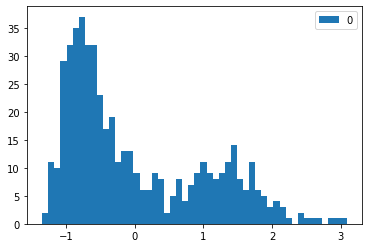

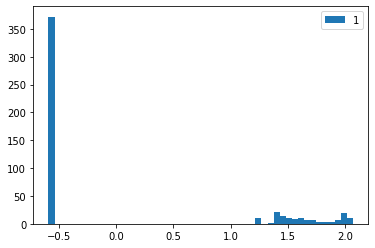

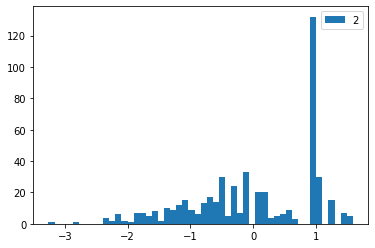

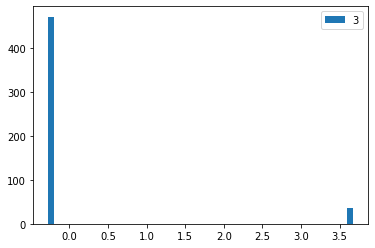

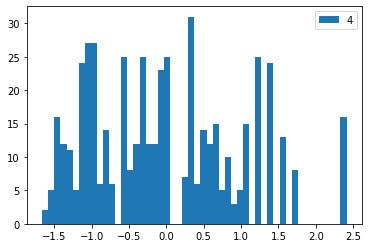

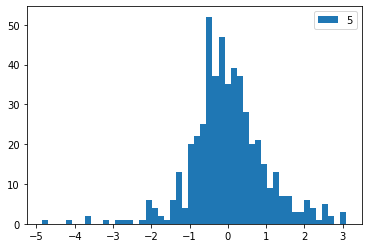

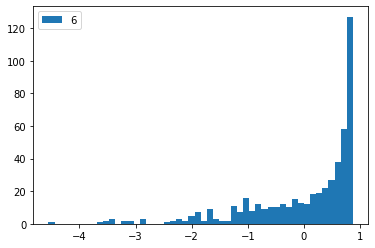

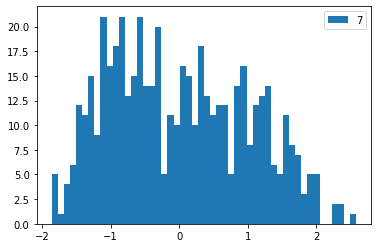

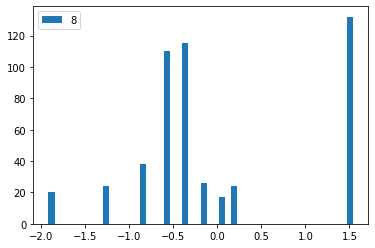

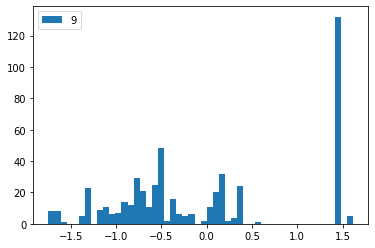

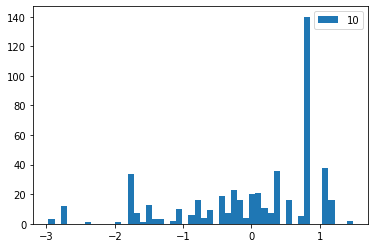

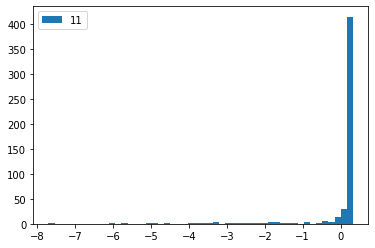

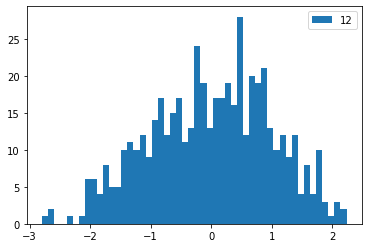

In [8]:
for i in range(x.shape[1]):
    plt.hist(x_scaled[:,i], bins=50, label=str(i))
    plt.legend()
    plt.show()

[]

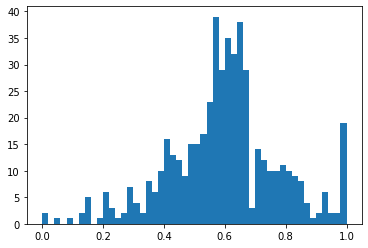

In [9]:
plt.hist(y, bins=50)
plt.plot()

In [10]:
# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x_scaled,
                                    y, test_size=0.2,
                                    random_state=42)

In [11]:
# Convert data to tensors
x_tr = torch.FloatTensor(x_train)
x_te = torch.FloatTensor(x_test)

In [12]:
y_tr = torch.FloatTensor(y_train).reshape(-1,1)
y_te = torch.FloatTensor(y_test).reshape(-1,1)

In [13]:
y_tr.shape

torch.Size([404, 1])

In [14]:
# Model architecture
class AnnModel(nn.Module):
    def __init__(self, inp_feats=13, h1=32, h2=16, out_feats=1):
        # Define layers
        super(AnnModel, self).__init__()
        self.fc1 = nn.Linear(inp_feats, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, out_feats)
        
    def forward(self, x):
        out = torch.relu(self.fc1(x))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out
 

In [15]:
# Set the seed
seed = 42
torch.manual_seed(seed)

In [16]:
# Instantiate the model
model = AnnModel()

In [17]:
# Error criterion
criterion = nn.MSELoss()

# Define optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.0006)

In [18]:
# Setup training loop
num_epochs = 300
train_loss = []
test_loss = []

In [19]:
# Track model training time
t1 = time.time()

for i in range(num_epochs):
    # Remove previous gradients
    optim.zero_grad()

    # Score the input from model
    y_pred = model(x_tr)

    # Calculate loss
    loss = criterion(y_pred, y_tr)

    # Calculate gradient
    loss.backward()

    # Apply gradient descent step
    optim.step()

    train_loss.append(loss.item())

    with torch.no_grad():
        y_eval = model(x_te)
        loss_eval = criterion(y_eval, y_te)
        test_loss.append(loss_eval.item())

    if (i)%50 == 0:
        print("Epoch: ",i+1, " Train Loss: ", 
            loss.item(), " Test Loss: ", loss_eval.item())

t2 = time.time()
print("Time Taken in Training: ", t2-t1)

Epoch:  1  Train Loss:  0.40536239743232727  Test Loss:  0.3758932054042816
Epoch:  51  Train Loss:  0.05506288260221481  Test Loss:  0.05353641137480736
Epoch:  101  Train Loss:  0.025058183819055557  Test Loss:  0.027079397812485695
Epoch:  151  Train Loss:  0.017036689445376396  Test Loss:  0.018672028556466103
Epoch:  201  Train Loss:  0.01225698459893465  Test Loss:  0.014012735337018967
Epoch:  251  Train Loss:  0.009250718168914318  Test Loss:  0.011606650426983833
Time Taken in Training:  0.31575584411621094


In [20]:
# Final evaluation
with torch.no_grad():
    y_train_eval = model(x_tr)
    y_test_eval = model(x_te)
    
    print(y_train_eval.shape)
    print(y_test_eval.shape)

torch.Size([404, 1])
torch.Size([102, 1])


In [21]:
# Convert torch tensors to numpy vectors
y_train_pred = y_train_eval.numpy()
y_test_pred = y_test_eval.numpy()

print(y_train_pred.shape)
print(y_test_pred.shape)

(404, 1)
(102, 1)


In [22]:
y_test_actual = y_te.reshape(-1,1).numpy()
y_train_actual = y_tr.reshape(-1,1).numpy()

print(y_train_actual.shape)
print(y_test_actual.shape)

(404, 1)
(102, 1)


In [23]:
# Rescale Y-varibale
def upscale(y, y_min, y_max):
    y = y*(y_max - y_min) + y_min
    return y

In [24]:
y_train_pred = upscale(y_train_pred, Y_Min, Y_Max)
y_test_pred = upscale(y_test_pred, Y_Min, Y_Max)

print(y_train_pred.shape)
print(y_test_pred.shape)

(404, 1)
(102, 1)


In [25]:
y_test_actual = upscale(y_test_actual, Y_Min, Y_Max)
y_train_actual = upscale(y_train_actual, Y_Min, Y_Max)

In [26]:
# RMSE function
def rmse(actuals, preds):
    print(actuals.shape)
    print(preds.shape)
    assert actuals.shape[0] == preds.shape[0]
    err = np.sqrt(np.mean((actuals - preds)**2))
    return err

In [27]:
# RMSE Report
train_report = rmse(y_train_actual, y_train_pred)
test_report = rmse(y_test_actual, y_test_pred)

print("RMSE Report:")
print("Train: ", train_report)
print("Test: ", test_report)

(404, 1)
(404, 1)
(102, 1)
(102, 1)
RMSE Report:
Train:  0.04731948
Test:  0.05617648


In [28]:
# MAPE Report
def mape(actuals, preds):
    assert actuals.shape[0] == preds.shape[0]
    err = np.mean(np.abs(actuals - preds)/actuals)
    return err

In [29]:
# MAPE
train_acc = mape(y_train_actual, y_train_pred)
test_acc = mape(y_test_actual, y_test_pred)

print("MAPE:")
print("Train: ", train_acc)
print("Test: ", test_acc)

MAPE:
Train:  0.027390225
Test:  0.030211335


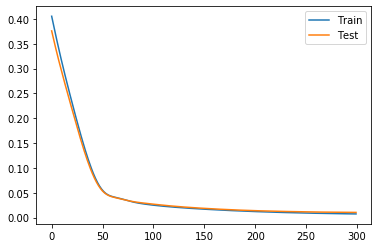

In [30]:
# Plot training curve
plt.plot(train_loss, label="Train")
plt.plot(test_loss, label="Test")
plt.legend()
plt.show()

In [31]:
# Grid search implementation from skorch

In [32]:
from skorch import NeuralNetRegressor

/Users/sachin/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [44]:
tuner = NeuralNetRegressor(
            model.double(),
            max_epochs=50,
            lr=0.0005,
            iterator_train__shuffle=True)

In [45]:
tuner.fit(x_scaled, Y.reshape(-1,1))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       10.3867        7.1321  0.0192
      2       10.3632        6.9990  0.0193
      3       10.3618        6.9437  0.0178
      4       10.3498        6.9327  0.0183
      5       10.3226        6.9612  0.0170
      6       10.3190        6.9776  0.0161
      7       10.3043        6.9632  0.0160
      8       10.2911        7.0095  0.0164
      9       10.2831        6.9409  0.0175
     10       10.2827        6.9914  0.0164
     11       10.2681        7.0594  0.0166
     12       10.2494        7.1377  0.0170
     13       10.2390        7.0013  0.0167
     14       10.2376        7.1044  0.0154
     15       10.2187        7.1762  0.0164
     16       10.2184        7.2279  0.0153
     17       10.2604        7.2316  0.0168
     18       10.2063        7.1137  0.0164
     19       10.1825        7.2228  0.0164
     20       10.1800        7.2049  0.0164
     21       10.1727        7.1

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=AnnModel(
    (fc1): Linear(in_features=13, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=1, bias=True)
  ),
)

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
params = {
    'lr' : [0.0004, 0.0005, 0.0006, 0.0007],
    'max_epochs' : [10, 20, 30]
}

In [37]:
tuner2 = NeuralNetRegressor(
            model.double(),
            iterator_train__shuffle=True
        )

In [38]:
grid = GridSearchCV(tuner2, params, refit=False, cv=5, scoring='neg_root_mean_squared_error')

In [39]:
grid.fit(x_scaled, Y.reshape(-1,1))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       25.8972       11.5709  0.0110
      2       23.6186       10.4398  0.0129
      3       21.8654        9.7195  0.0132
      4       20.7603        9.3686  0.0133
      5       20.0614        9.0527  0.0130
      6       19.4367        8.8554  0.0128
      7       19.0429        8.7775  0.0128
      8       18.7707        8.7484  0.0129
      9       18.5656        8.7073  0.0123
     10       18.3560        8.6658  0.0128
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       23.8639        6.2697  0.0123
      2       22.4425        5.8637  0.0133
      3       21.2461        5.6165  0.0123
      4       20.3100        5.4650  0.0129
      5       19.6221        5.3945  0.0131
      6       19.1695        5.3592  0.0133
      7       18.8651        5.3223  0.0135
      8       18.5957        5.3034  0.0137
      9       18.3677        5.2

     15       11.7489        5.5670  0.0128
     16       11.6352        5.6100  0.0121
     17       11.5424        5.6165  0.0114
     18       11.4491        5.6241  0.0118
     19       11.3856        5.6485  0.0121
     20       11.3255        5.6572  0.0120
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       23.4952        6.0058  0.0110
      2       20.8546        5.6017  0.0127
      3       19.3551        5.4500  0.0125
      4       18.4379        5.4352  0.0119
      5       17.8300        5.4579  0.0112
      6       17.5434        5.4719  0.0116
      7       17.3322        5.4964  0.0123
      8       17.1174        5.5193  0.0126
      9       16.9799        5.5095  0.0122
     10       16.8483        5.5492  0.0125
     11       16.7014        5.5547  0.0113
     12       16.5868        5.5392  0.0122
     13       16.5072        5.5216  0.0123
     14       16.4103        5.5526  0.0124
     15       16.3114        5.5

     18       11.4545        5.6156  0.0138
     19       11.4047        5.6668  0.0138
     20       11.3149        5.6627  0.0130
     21       11.2549        5.6763  0.0130
     22       11.2024        5.6098  0.0129
     23       11.1522        5.6573  0.0133
     24       11.0922        5.6460  0.0122
     25       11.0649        5.6182  0.0119
     26       10.9914        5.5958  0.0123
     27       10.9466        5.6260  0.0114
     28       10.9020        5.6188  0.0120
     29       10.8605        5.6004  0.0114
     30       10.8359        5.6481  0.0125
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       23.5480        6.0504  0.0112
      2       21.1395        5.6570  0.0128
      3       19.5875        5.4683  0.0121
      4       18.6070        5.4150  0.0117
      5       18.0259        5.4209  0.0119
      6       17.6782        5.4424  0.0128
      7       17.4008        5.4759  0.0123
      8       17.1680        5.4

     18       16.7200        5.1060  0.0122
     19       16.6324        5.0800  0.0154
     20       16.5438        5.0829  0.0148
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       24.1783        6.3335  0.0108
      2       22.6062        5.9644  0.0127
      3       21.3722        5.7178  0.0120
      4       20.4652        5.5796  0.0123
      5       19.7544        5.4738  0.0109
      6       19.2325        5.4103  0.0123
      7       18.8235        5.3661  0.0123
      8       18.5209        5.3415  0.0121
      9       18.3161        5.3214  0.0124
     10       18.1024        5.3016  0.0113
     11       17.9594        5.2906  0.0122
     12       17.7194        5.2816  0.0124
     13       17.5736        5.2691  0.0124
     14       17.4576        5.2490  0.0121
     15       17.3198        5.2392  0.0124
     16       17.1749        5.2179  0.0116
     17       17.0541        5.2002  0.0129
     18       16.9535        5.1

     10       17.9885        5.3064  0.0157
     11       17.7928        5.2916  0.0143
     12       17.6090        5.2726  0.0143
     13       17.4763        5.2632  0.0145
     14       17.3310        5.2315  0.0157
     15       17.1981        5.2174  0.0136
     16       17.1008        5.2026  0.0131
     17       17.0417        5.1801  0.0135
     18       16.9092        5.1459  0.0128
     19       16.7912        5.1305  0.0134
     20       16.6978        5.1126  0.0131
     21       16.5871        5.1097  0.0144
     22       16.5215        5.0855  0.0142
     23       16.4263        5.0811  0.0138
     24       16.3236        5.0625  0.0132
     25       16.2647        5.0565  0.0134
     26       16.1470        5.0500  0.0131
     27       16.0669        5.0345  0.0128
     28       15.9821        5.0165  0.0146
     29       15.9389        5.0058  0.0126
     30       15.8109        5.0002  0.0129
  epoch    train_loss    valid_loss     dur
-------  ------------  ---------

      2       22.6080        9.8091  0.0122
      3       20.8228        9.2229  0.0129
      4       19.6784        8.9161  0.0116
      5       19.0192        8.7744  0.0111
      6       18.6977        8.7412  0.0114
      7       18.4269        8.6970  0.0117
      8       18.1252        8.6812  0.0125
      9       17.8982        8.6863  0.0127
     10       17.7162        8.6775  0.0124
     11       17.5763        8.6763  0.0119
     12       17.4102        8.6948  0.0117
     13       17.2753        8.6929  0.0112
     14       17.1428        8.7283  0.0128
     15       17.0227        8.7474  0.0124
     16       16.8884        8.7649  0.0127
     17       16.8150        8.7901  0.0122
     18       16.6784        8.7831  0.0116
     19       16.5982        8.8100  0.0112
     20       16.5096        8.8204  0.0115
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       23.6431        6.0505  0.0099
      2       21.6857        5.6

      6       18.6050        5.2854  0.0118
      7       18.2182        5.2766  0.0131
      8       17.9716        5.2521  0.0119
      9       17.7671        5.2241  0.0113
     10       17.5676        5.2012  0.0114
     11       17.3835        5.1850  0.0121
     12       17.2098        5.1714  0.0120
     13       17.0102        5.1608  0.0123
     14       16.8931        5.1235  0.0116
     15       16.7487        5.1061  0.0115
     16       16.6058        5.1015  0.0112
     17       16.4814        5.0893  0.0118
     18       16.4191        5.0898  0.0123
     19       16.2897        5.0820  0.0122
     20       16.1892        5.0338  0.0120
     21       16.0736        5.0136  0.0117
     22       16.0218        5.0088  0.0117
     23       15.8773        4.9924  0.0119
     24       15.7797        4.9890  0.0118
     25       15.6923        4.9701  0.0125
     26       15.6295        4.9547  0.0129
     27       15.5926        4.9596  0.0120
     28       15.4483        4.9

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       24.0190        6.1123  0.0113
      2       21.9958        5.7401  0.0114
      3       20.6832        5.5432  0.0123
      4       19.6886        5.4281  0.0116
      5       19.0482        5.3765  0.0125
      6       18.5305        5.3449  0.0123
      7       18.2279        5.3347  0.0127
      8       17.9183        5.3186  0.0123
      9       17.7081        5.2763  0.0127
     10       17.5314        5.2429  0.0131
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       17.7642        5.7597  0.0112
      2       14.8990        5.4350  0.0135
      3       13.5286        5.4231  0.0111
      4       12.9032        5.4881  0.0122
      5       12.5255        5.5880  0.0127
      6       12.2730        5.6076  0.0126
      7       12.0318        5.5864  0.0128
      8       11.8790        5.5186  0.0136
      9       11.6908        5.6

      2       22.1168        9.5135  0.0144
      3       20.2104        8.9452  0.0136
      4       19.1295        8.7450  0.0131
      5       18.6218        8.6701  0.0129
      6       18.2251        8.6441  0.0125
      7       17.9821        8.6443  0.0129
      8       17.7065        8.6259  0.0134
      9       17.5333        8.6272  0.0131
     10       17.3292        8.6544  0.0135
     11       17.1569        8.6525  0.0142
     12       17.0348        8.6367  0.0136
     13       16.8925        8.6573  0.0129
     14       16.8095        8.7037  0.0130
     15       16.6362        8.7349  0.0127
     16       16.5342        8.7613  0.0126
     17       16.4244        8.7500  0.0118
     18       16.2885        8.7691  0.0128
     19       16.1906        8.8282  0.0126
     20       16.0760        8.8734  0.0131
     21       16.0059        8.9097  0.0129
     22       15.9297        8.9155  0.0132
     23       15.8303        8.9176  0.0129
     24       15.7668        8.9

     20       15.1183        5.4652  0.0153
     21       15.0211        5.4701  0.0146
     22       14.8948        5.4752  0.0144
     23       14.8269        5.5139  0.0139
     24       14.7435        5.5057  0.0136
     25       14.6871        5.4674  0.0128
     26       14.6078        5.4475  0.0127
     27       14.5326        5.4992  0.0114
     28       14.5235        5.4790  0.0120
     29       14.4356        5.4615  0.0120
     30       14.3459        5.4822  0.0118


GridSearchCV(cv=5, error_score=nan,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=AnnModel(
    (fc1): Linear(in_features=13, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=1, bias=True)
  ),
),
             iid='deprecated', n_jobs=None,
             param_grid={'lr': [0.0004, 0.0005, 0.0006, 0.0007],
                         'max_epochs': [10, 20, 30]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [40]:
print(grid.best_score_, grid.best_params_)

-3.7233938941823306 {'lr': 0.0007, 'max_epochs': 30}
